In [2]:
# Packages
import pickle
from community import community_louvain
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import itertools
from fa2 import ForceAtlas2
from operator import itemgetter

In [3]:
# Load data
super_hero_dict = pickle.load( open( "../Data/super_hero_dict_formatted.pickle", "rb" ) )

# Read undirected graph based on GCC
G = nx.read_gpickle("../Data/GCC_undirected.pickle")

G_marvel = G.subgraph([superhero for superhero, universe in nx.get_node_attributes(G, 'Universe').items() if universe == 'Marvel'])
G_dc = G.subgraph([superhero for superhero, universe in nx.get_node_attributes(G, 'Universe').items() if universe == 'DC'])

In [62]:
np.random.seed(42)

# Part 3: Communities and TF-IDF

In this part the structure of the graph will be investigated closer by looking at *communities* of the data. The optimal partition will be found using the *Louvain method*. Afterwards these communities will be considered as once entitiy and their wikitext will be treated as a single *document*. Based on this they can be charactarized based on the TF-IDF, where the collection of documents based on the communities are the corpus.

**Find the communities. Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?**

In part 3 and 4 only the Marvel universe will be considered by using the `G_marvel` graph why the communities of this unvierse will be found. This partition will be found the the Louvain method. The algorithm works by iteratively going through the two following steps:

1) All nodes in the network are assigned to their own individual community. For all nodes $i$ the change in modulatiry is calculated when the node $i$ is moved into its neigbour $j$'s community. This is done for all neighbors of $i$ and $i$ is then moved into the community that leads to the greatest increase in modularity. If the modularity can not be increased $i$ stays. If no *merge* can lead to an increased modularity the algorithm terminates.

2) All nodes that now have become a community are merged into one node. The links between nodes in that community are made into self-loops while weighted links will be used to represent multiple links between a community. On this new graph step 1) can be applied again.

The method is used as it is quite simple to understand. By passing the argument `randomize = False` to the function it also becomes deterministic which is nice for reproduceability. With the `community_louvain.best_partition` function the optimal partition can also be calculated very fast, which is off course also nice.

The partition is calculated below where the output also is shown:

In [63]:
communitiesMarvel = community_louvain.best_partition(G_marvel, randomize = False)

# Show data structure
communitiesMarvel

{'A-Bomb': 0,
 'Abomination': 1,
 'Ajak': 2,
 'Ajax': 2,
 'Amphibius': 3,
 'Anansi': 3,
 'Anelle': 1,
 'Arishem the Judge': 1,
 'Avoe': 1,
 'Brian Banner': 4,
 'Banshee': 5,
 'Barbarus': 3,
 'Baron Blood': 0,
 'Baron Brimstone': 6,
 'Baron Mordo': 7,
 'Baron Strucker': 0,
 'Baron Zemo': 0,
 'Barracuda': 1,
 'Breeze Barton': 4,
 'Bast': 6,
 'Bastion': 5,
 'Batroc the Leaper': 0,
 'Battlestar': 6,
 'Batwing': 4,
 'Beast': 5,
 'Beautiful Dreamer': 5,
 'Bedlam': 3,
 'Beef': 5,
 'Beetle': 3,
 'Belasco': 6,
 'Bella Donna': 6,
 'Bengal': 1,
 'Bereet': 1,
 'Berzerker': 5,
 'Beta Ray Bill': 1,
 'Beyonder': 1,
 'Bi-Beast': 4,
 'Big Bertha': 4,
 'Big Man': 3,
 'Big Wheel': 3,
 'Bird-Man': 6,
 'Bishop': 5,
 'Black Ant': 0,
 'Black Bolt': 1,
 'Black Box': 6,
 'Black Cat': 3,
 'Black Crow': 7,
 'Black Dwarf': 1,
 'Black Jack Tarr': 3,
 'Black Knight': 0,
 'Black Mamba': 6,
 'Black Marvel': 6,
 'Black Panther': 0,
 'Black Racer': 6,
 'Black Rider': 4,
 'Black Spectre': 3,
 'Black Swan': 1,
 'Black Ta

Now this dictionaty is *reversed* so it is possible to easily find the nodes, i.e. super heroes, that belongs to a given community. The output is also illustrated:

In [64]:
communities_dict = {c: [k for k,v in communitiesMarvel.items() if v == c] 
                    for c in set(communitiesMarvel.values())}

# Show data structure
communities_dict

{0: ['A-Bomb',
  'Baron Blood',
  'Baron Strucker',
  'Baron Zemo',
  'Batroc the Leaper',
  'Black Ant',
  'Black Knight',
  'Black Panther',
  'Blacklash',
  'Blank',
  'Blizzard',
  'Bloodshed',
  'Blue Eagle',
  'Calamity',
  'Capricorn',
  'Carnivore',
  'Challenger',
  'Chemistro',
  'Cheshire Cat',
  'Cobalt Man',
  'Coldblood',
  'Comanche',
  'Conquest',
  'Controller',
  'Crimson Dynamo',
  'Crossbones',
  'Crusher',
  'Darkstar',
  'Deathlok',
  'Detroit Steel',
  'Digitek',
  'Doc Samson',
  'Doctor Spectrum',
  'Dracula',
  'Dreadknight',
  'Dreadnought',
  'Egghead',
  'Enchantress',
  'Falcon',
  'Firepower',
  'Fixer',
  'Flying Tiger',
  'Force',
  'Foxfire',
  'Freak',
  'Friday',
  'Friction',
  'Ghost',
  'Giant-Man',
  'GoGo Tomago',
  'Golden Archer',
  'Goliath',
  'Grasshopper',
  'Griffin',
  'Grim Reaper',
  'Guardsman',
  'Hate-Monger',
  'Haywire',
  'Hermes',
  'Happy Hogan',
  'Hollywood',
  'Honey Lemon',
  'Human Top',
  'Hyperion',
  'Hypnotia',
  'Immo

Let's also have a look at resulting modularity of the partition

In [65]:
nx.algorithms.community.quality.modularity(G_marvel, list(communities_dict.values()))

0.3697382073255283

An ideal modularity is 1 but this is not expected to be seen in an real network. When considering the structure of the network of a single universe - as illustrated in part 1 - it is very connected and it is hard to come by well seperated communities. Therefore the modularity of $Q=0.37$ is not unexpected as the optimal found by the Lauvain method.

**How many communities did you find in total?**

This is calculated as the number of elements in the `communities_dict`:

In [66]:
len(communities_dict)

20

A total of 20 communities are found which that there are around 67 nodes on average in a community. The fact that relatively many are found.also support the point stated above where there are not really many well seperated communities.

**Plot the distribution of community sizes.**

Even though the average of around 67 nodes per community easily are calculated it is interesting to look at the actual distribution of community sizes. This is easily done in a bar plot based on the `communities_dict` where the number of super heroes in a community becomes the height. This is done below:

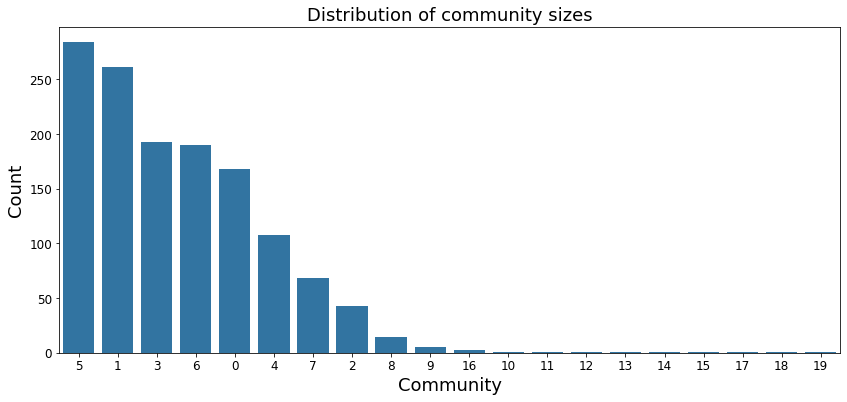

In [67]:
# List to sort according to size
com_size_order = sorted(communities_dict, key = lambda k: len(communities_dict[k]), reverse = True)

plt.figure(figsize = (14,6))
sns.barplot(
    x = list(communities_dict.keys()), 
    y = [len(com) for com in communities_dict.values()], 
    order = com_size_order,
    color = "tab:blue"
)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Community", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.title("Distribution of community sizes", fontsize = 18)
plt.show()

By looking at this plot it is very clear that the distribution is no way near uniform. Some communnities ends up with more than 250 nodes there is also a handfull with just one node. With a network with so many nodes and links it is hard to fully justify 

In [68]:
sorted([len(com) for com in communities_dict.values()], reverse = True)

[284, 261, 193, 190, 168, 108, 68, 43, 14, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [69]:
# https://sashamaps.net/docs/resources/20-colors/
color_dict = {0: '#e6194B', 1: '#3cb44b', 2: '#ffe119', 3:'#4363d8', 4:'#f58231', 5:'#911eb4', 6:'#42d4f4', 7:'#f032e6', 8:'#bfef45', 9:'#fabed4', 10:'#469990', 11:'#dcbeff', 12:'#9A6324', 13:'#fffac8', 14:'#800000', 15:'#aaffc3', 16:'#808000', 17:'#ffd8b1', 18:'#000075',19:'#515151'}

In [70]:
[color_dict[communitiesMarvel[char]] for char in G_marvel.nodes]

['#e6194B',
 '#3cb44b',
 '#ffe119',
 '#ffe119',
 '#4363d8',
 '#4363d8',
 '#3cb44b',
 '#3cb44b',
 '#3cb44b',
 '#f58231',
 '#911eb4',
 '#4363d8',
 '#e6194B',
 '#42d4f4',
 '#f032e6',
 '#e6194B',
 '#e6194B',
 '#3cb44b',
 '#f58231',
 '#42d4f4',
 '#911eb4',
 '#e6194B',
 '#42d4f4',
 '#f58231',
 '#911eb4',
 '#911eb4',
 '#4363d8',
 '#911eb4',
 '#4363d8',
 '#42d4f4',
 '#42d4f4',
 '#3cb44b',
 '#3cb44b',
 '#911eb4',
 '#3cb44b',
 '#3cb44b',
 '#f58231',
 '#f58231',
 '#4363d8',
 '#4363d8',
 '#42d4f4',
 '#911eb4',
 '#e6194B',
 '#3cb44b',
 '#42d4f4',
 '#4363d8',
 '#f032e6',
 '#3cb44b',
 '#4363d8',
 '#e6194B',
 '#42d4f4',
 '#42d4f4',
 '#e6194B',
 '#42d4f4',
 '#f58231',
 '#4363d8',
 '#3cb44b',
 '#911eb4',
 '#4363d8',
 '#911eb4',
 '#911eb4',
 '#e6194B',
 '#f58231',
 '#42d4f4',
 '#f58231',
 '#f032e6',
 '#e6194B',
 '#3cb44b',
 '#42d4f4',
 '#911eb4',
 '#4363d8',
 '#911eb4',
 '#911eb4',
 '#911eb4',
 '#e6194B',
 '#911eb4',
 '#911eb4',
 '#f58231',
 '#3cb44b',
 '#f032e6',
 '#bfef45',
 '#42d4f4',
 '#4363d8',
 '#e

100%|██████████| 200/200 [00:10<00:00, 18.35it/s]


BarnesHut Approximation  took  3.13  seconds
Repulsion forces  took  7.37  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


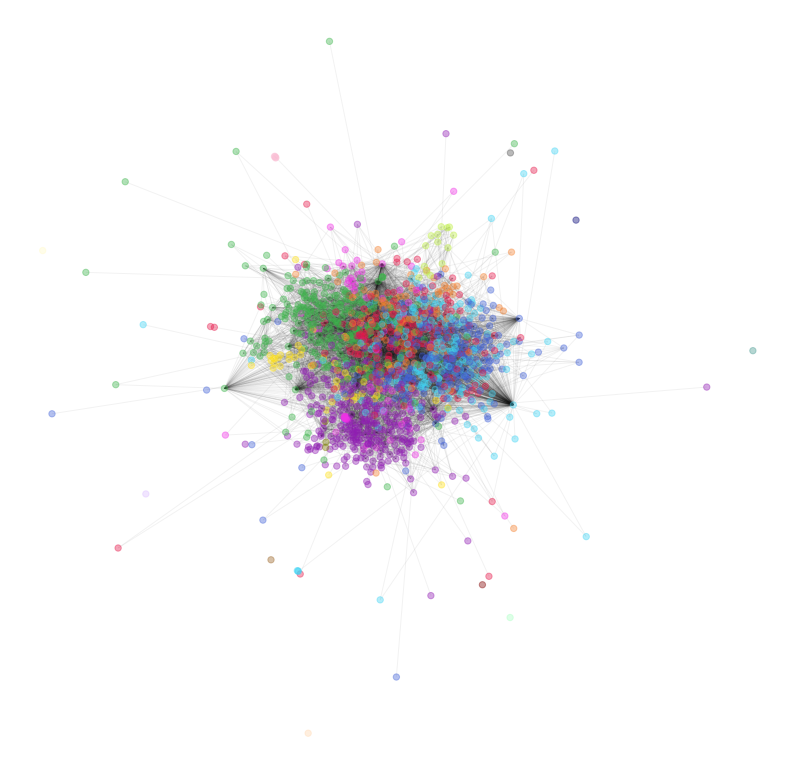

In [71]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    edgeWeightInfluence = 0.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=0.1,
    gravity=1.0,

    # Log
    verbose=True
)

plt.figure(figsize=(14,14))
positions = forceatlas2.forceatlas2_networkx_layout(G_marvel, pos=None, iterations=200)

nx.draw_networkx_nodes(
    G = G_marvel,
    node_size = 40,
    pos = positions, 
    node_color=[color_dict[communitiesMarvel[char]] for char in G_marvel.nodes],
    alpha=0.4
)

nx.draw_networkx_edges(
    G = G_marvel,
    pos = positions, 
    edge_color = "k", 
    alpha=0.05
)
plt.axis('off')
plt.show()

**For the 5-10 largest communities, create TF-IDF based rankings of words in each community.**

In [72]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

In [73]:
# Number of communities to consider
LC = 10

token_dict = {com: tokenizer.tokenize(
                " ".join([super_hero_dict[char]['Wiki_text'] for char in communities_dict[com] 
                if super_hero_dict[char]['Wiki_text'] is not None])
                ) for com in com_size_order[:LC] 
             }

TF_dict = {key: nltk.FreqDist(value) for key, value in token_dict.items()}

Explain TF_IDF

* raw count for TF (not normalizing as the TF for each community is not compared with the TF for the others
* inverse document freq for IDF

In [74]:
all_words = set(list(itertools.chain(*token_dict.values())))
N = len(TF_dict)
idf = {key: np.log(N / sum([tf[key] > 0 
            for k, tf in TF_dict.items()])) 
            for key in all_words
      }

In [75]:
# Storing TF-IDF in a dataframe
TF_IDF = pd.DataFrame(index = TF_dict.keys(), columns = all_words)

for word in TF_IDF.columns:
    for idx in TF_IDF.index:
        TF_IDF.loc[idx, word] = TF_dict[idx][word] * idf[word]

Assignment operator

In [76]:
TF_IDF

,experience,resign,Daley,locator,slashed,bitterness,11095,sculpture,Room,dimension,...,repository,ray,collaborated,cachet,both,Sarnak,592,Jonin,shaggy,Unstable
5,5.90019,4.15888,0,1.60944,11.2661,2.74887,2.30259,0,26.3939,45.5213,...,6.01986,2.14005,0.510826,0,66.4825,0,0,2.30259,0,0
1,3.68762,0.693147,1.60944,0,0,0,0,4.82831,4.63677,28.7855,...,1.20397,11.4136,4.59743,0,30.1331,0,1.20397,0,2.30259,0
3,3.26618,1.38629,0,0,1.60944,1.83258,0,1.60944,0.356675,15.8432,...,0,3.56675,4.0866,0,35.5065,0,0,0,0,4.60517
6,2.52865,2.07944,1.60944,1.60944,0,0,0,0,0.71335,13.6118,...,0,9.63022,0.510826,0,19.3863,4.60517,1.20397,0,0,0
0,3.4769,0.693147,0,0,0,0.916291,0,0,3.21007,13.1655,...,0,11.7703,3.06495,4.60517,22.9686,0,0,0,0,0
4,1.36969,0,0,0,0,0,0,0,1.4267,3.79344,...,0,2.14005,0,0,11.4843,0,1.20397,0,0,0
7,0.737524,0,0,0,0,0.916291,0,0,1.07002,11.3803,...,0,0.356675,2.55413,0,6.84843,0,0,0,0,0
2,0.210721,0,0,0,0,0,0,0,0,2.90087,...,0,0,0,0,5.68947,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,1.20397,0,0,0,0.842884,0,0,0,0,0
9,0.105361,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Create a word-cloud displaying the most important words in each community (according to TF-IDF)**

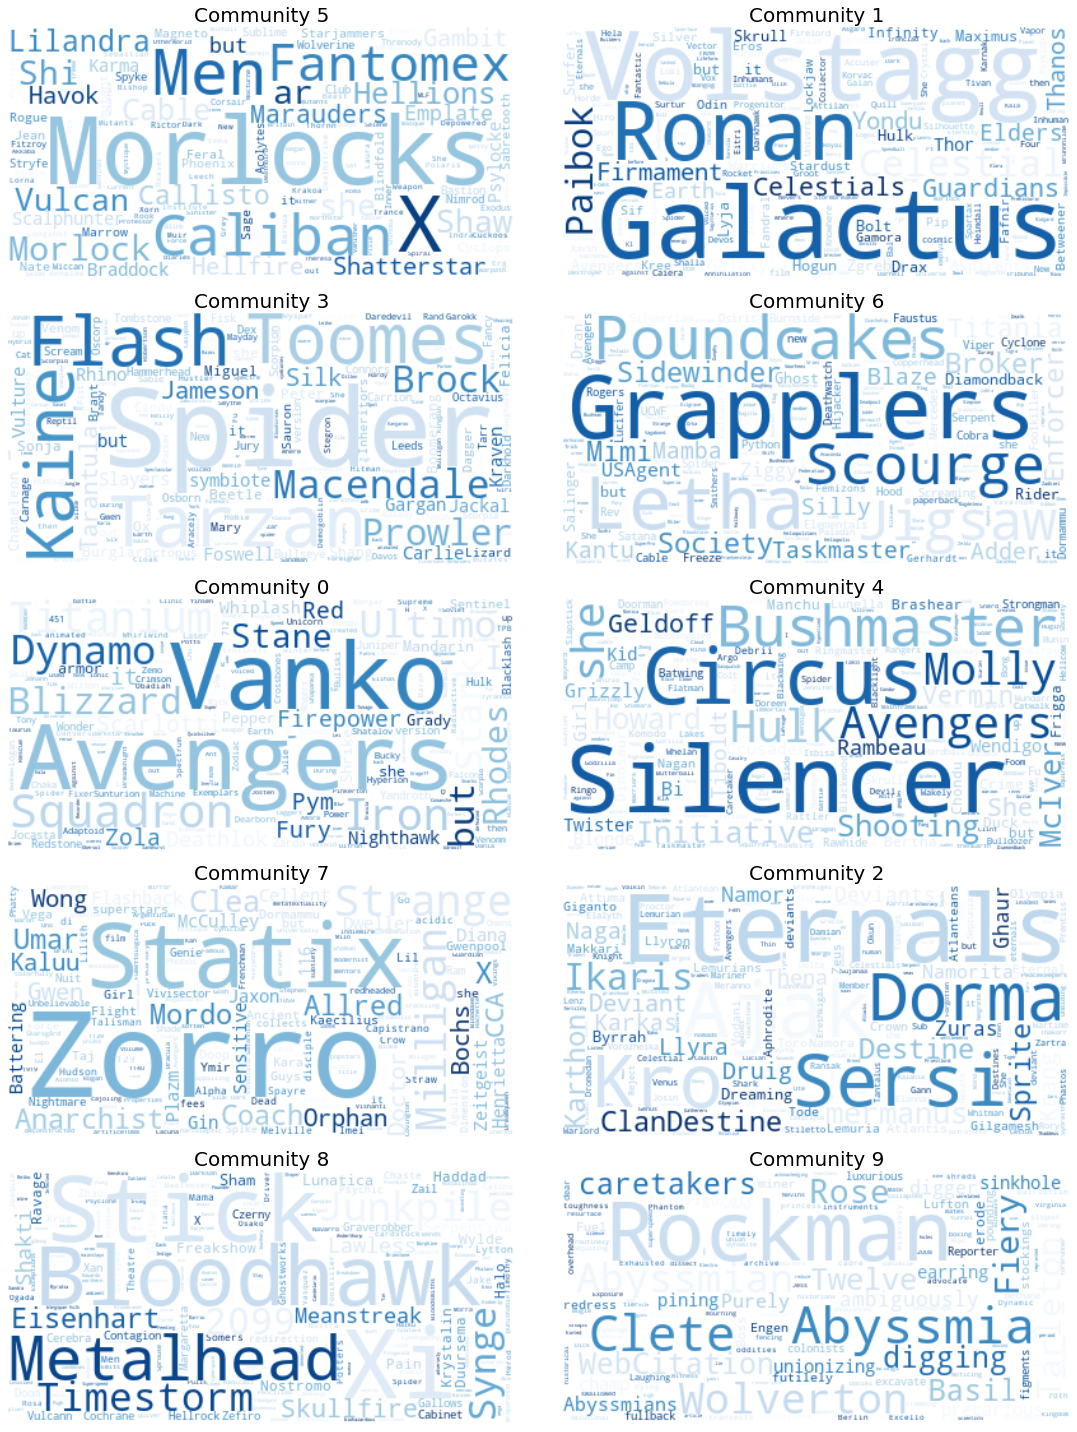

In [77]:
fig, axs = plt.subplots(5, 2, sharey=True, tight_layout=True, figsize = (16,20))

for p, (com, words) in enumerate(dict(zip(TF_IDF.index, TF_IDF.to_dict(orient = 'records'))).items()):
    import wordcloud
    wordcloud = wordcloud.WordCloud(colormap = "Blues", background_color = "white")
    wordcloud.generate_from_frequencies(frequencies=words)
    axs[p//2, p%2].imshow(wordcloud, interpolation="bilinear")
    axs[p//2, p%2].axis("off")
    axs[p//2, p%2].set_title(f"Community {com}", fontsize = 20)

plt.show()

# Part 4: Sentiment Analysis

In order to do sentiment analysis on the communities, each community is named by its three most connected characters. The most connected characters are determined based on their links in the graph `G_marvel`. Since the graph is undirected most connected is determined based on their overall degree. 

A function `three_most_connected`is created such that the input is a community from the dictionary containing all communities in the Marvel universe. It then calculates the degree of all superheros in that particular community and returns the three superheros with the highest degree. So through the analysis, one can use this function to look up the new 'name' of each community. 

In [78]:
def three_most_connected(superheros):
    degree_dict = dict(G_marvel.degree(superheros))
    return [k for k, v in dict(sorted(degree_dict.items(), key = itemgetter(1), reverse = True)[:3]).items()]

**Calculate and store sentiment for every single page.**

For the sentiment analysis, Data Set S1 (the LabMT wordlist) from [https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752] is used. It contains many many words all with a so-called happiness average. Sentiment for every single page of the Marvel universe is determined using this LabMT wordlist. However, a clear difference in sentiment is not expected since all words are from Wikipedia. The wiki-texts are written in a predominantly neutral language. This means that all sentiment values should be positioned around a value of 5. Despite of this fact, an analysis is still performed in order to gather information about the Marvel universe. 

In [79]:
# Load LabMT wordlist
sentiment_table = pd.read_table('../Data/Sentiment.txt', delimiter="\t")
sentiment_table

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107


For keeping track of all words in the LabMT wordlist and their corresponding happiness average, data is gathered in a dictionary. 

In [80]:
sentiment_dict = dict(zip(sentiment_table['word'],sentiment_table['happiness_average']))
sentiment_dict

{'laughter': 8.5,
 'happiness': 8.44,
 'love': 8.42,
 'happy': 8.3,
 'laughed': 8.26,
 'laugh': 8.22,
 'laughing': 8.2,
 'excellent': 8.18,
 'laughs': 8.18,
 'joy': 8.16,
 'successful': 8.16,
 'win': 8.12,
 'rainbow': 8.1,
 'smile': 8.1,
 'won': 8.1,
 'pleasure': 8.08,
 'smiled': 8.08,
 'rainbows': 8.06,
 'winning': 8.04,
 'celebration': 8.02,
 'enjoyed': 8.02,
 'healthy': 8.02,
 'music': 8.02,
 'celebrating': 8.0,
 'congratulations': 8.0,
 'weekend': 8.0,
 'celebrate': 7.98,
 'comedy': 7.98,
 'jokes': 7.98,
 'rich': 7.98,
 'victory': 7.98,
 'christmas': 7.96,
 'free': 7.96,
 'friendship': 7.96,
 'fun': 7.96,
 'holidays': 7.96,
 'loved': 7.96,
 'loves': 7.96,
 'loving': 7.96,
 'beach': 7.94,
 'hahaha': 7.94,
 'kissing': 7.94,
 'sunshine': 7.94,
 'beautiful': 7.92,
 'delicious': 7.92,
 'friends': 7.92,
 'funny': 7.92,
 'outstanding': 7.92,
 'paradise': 7.92,
 'sweetest': 7.92,
 'vacation': 7.92,
 'butterflies': 7.92,
 'freedom': 7.9,
 'flower': 7.88,
 'great': 7.88,
 'sunlight': 7.88,
 

A function `sentimentcalc` is created for calculating sentiment of each word. The function takes a list of tokens as input and look up the sentiment value in the LabMT wordlist. The function returns the average sentiment of each superhero in each community. 

In [81]:
def sentimentcalc(tokens):
    sents = [sentiment_dict[word] for word in tokens if word in sentiment_dict.keys()]
    if len(sents) == 0:
        return np.nan
    else:
        return np.mean(sents)

All wiki-texts in the dictionary containing superheros and their corresponding wiki-text, are tokenized into a list and all words are set to lowercase. 

In [82]:
tokens = {k: tokenizer.tokenize(v['Wiki_text'].lower()) 
          for k,v in super_hero_dict.items() 
          if v['Wiki_text'] is not None
         }

The sentiment values can then be calculated using the function presented above. 

In [83]:
sentiment_value = {k: sentimentcalc(v) 
                   for k,v in tokens.items() 
                   if sentimentcalc(v) is not np.nan
                  }
sentiment_value

{'A-Bomb': 5.273619740813066,
 'Abomination': 5.213429802955665,
 'Ajak': 5.3342779587405005,
 'Ajax': 5.3342779587405005,
 'Amphibius': 5.240660550458716,
 'Arishem the Judge': 5.3151296751296755,
 'Brian Banner': 5.237335423197492,
 'Banshee': 5.337167458432305,
 'Barbarus': 5.240660550458716,
 'Baron Blood': 5.295299479166667,
 'Baron Brimstone': 5.272326283987915,
 'Baron Mordo': 5.2676472883339835,
 'Baron Strucker': 5.229563210227273,
 'Baron Zemo': 5.270489192263937,
 'Barracuda': 5.276252905625291,
 'Breeze Barton': 5.377021276595745,
 'Bast': 5.400998363338789,
 'Bastion': 5.26251948051948,
 'Batroc the Leaper': 5.304212454212454,
 'Battlestar': 5.324772727272727,
 'Batwing': 5.333980848153215,
 'Baymax': 5.445027977617905,
 'Beast': 5.306312018819504,
 'Beautiful Dreamer': 5.505313725490196,
 'Bedlam': 5.381412103746398,
 'Beef': 5.3658582502768555,
 'Beetle': 5.2724928202182655,
 'Belasco': 5.310619223659889,
 'Bella Donna': 5.33720867208672,
 'Bengal': 5.284912587412588,
 '

**Create a histogram of all character's associated page-sentiments.**

Now that a dictionary containing all words and their sentiment values, a histogram can be created to get an overview of the values. 

<function matplotlib.pyplot.show(close=None, block=None)>

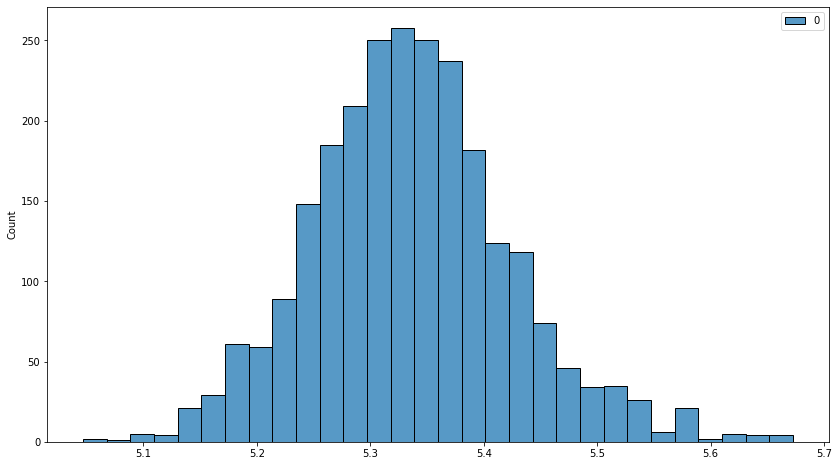

In [84]:
plt.figure(figsize = (14,8))
sns.histplot(sentiment_value.values(), bins = 30, color = "tab:blue")
plt.show

As expected, the sentiment values lie around a value of 5. This means that the wiki-texts are in fact written in a neutral language. It is possible to extract the happiest and saddest pages and communities but the difference in sentiment values are, as seen, quite narrow. 

**What are the 10 characters with happiest and saddest pages?**

The happiest and saddest pages can be determined by sorting the dictionary with the sentiment values in descending and ascending order respectively. There are many superheros in the Marvel universe, so only the 10 characters with happiest and saddest pages are investigated. 

In [85]:
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = True)[:10])

{'Jack B. Quick II': 5.6726016260162595,
 'Super Rabbit': 5.666722090261284,
 'Super-Turtle': 5.657616707616707,
 'Boone, Daniel': 5.656279069767442,
 'Bebe': 5.6444964028776985,
 'Biff Bronson': 5.642165841584159,
 'Bart Regan': 5.63772068511199,
 'Joanie Swift': 5.635828402366863,
 'Rainbow Girl': 5.628080495356037,
 'Buzzy Brown': 5.621750321750322}

In [86]:
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = False)[:10])

{'Death Metal': 5.046675257731959,
 'Sin-Eater': 5.062679509632225,
 'Hurricane': 5.082504873294347,
 'Superior': 5.09050185873606,
 'Savage Steel': 5.091127450980393,
 'Death': 5.099054662379421,
 'Clawster': 5.103204225352114,
 'Trash': 5.1047860538827265,
 'Razor Fist': 5.110126582278482,
 'Killer Shrike': 5.111051401869159}

**What are the three happiest communities?**

The sentiment values of each character are stored in a dictionary containing community number as key and the average sentiment of the characters in each community in order to find a community level sentiment.

In [87]:
sentiment_communities = {
                k: np.nanmean(
                    [sentimentcalc(tokenizer.tokenize(super_hero_dict[char]['Wiki_text'].lower())) 
                    for char in v if super_hero_dict[char]['Wiki_text'] is not None]
                            )
                for k, v in communities_dict.items()
                        }

sentiment_communities

/Users/IdaRiis/opt/anaconda3/envs/social_graphs/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


{0: 5.303609067573169,
 1: 5.317041908508568,
 2: 5.335591613604888,
 3: 5.285788089337912,
 4: 5.331478575763177,
 5: 5.302885797377022,
 6: 5.301591874838268,
 7: 5.3235743013017744,
 8: 5.293019631495868,
 9: 5.3916018852967795,
 10: 5.420921568627451,
 11: 5.313885017421603,
 12: nan,
 13: nan,
 14: 5.386773296244785,
 15: nan,
 16: 5.263915999134012,
 17: 5.366507177033493,
 18: 5.268609550561798,
 19: 5.177392795883362}

The three happiest communities are determined in the same way as for the characters. The sentiment values of each community are sorted in descending order and the top three are displayed.

In [88]:
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = True)[:3])

{10: 5.420921568627451, 9: 5.3916018852967795, 2: 5.335591613604888}

In [97]:
print('The three happiest communities are:')
print(three_most_connected(communities_dict[10]))
print(three_most_connected(communities_dict[9]))
print(three_most_connected(communities_dict[2]))

The three happiest communities are:
['Dionysus']
['Rockman', 'Blue Blade', 'Phantom Reporter']
['Namorita', 'Namor the Sub-Mariner', 'Brother Tode']


**What are the three saddest communities?**

In [98]:
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = False)[:3])

{19: 5.177392795883362, 16: 5.263915999134012, 18: 5.268609550561798}

In [99]:
print('The three saddest communities are:')
print(three_most_connected(communities_dict[19]))
print(three_most_connected(communities_dict[16]))
print(three_most_connected(communities_dict[18]))

The three saddest communities are:
['Thunderbolt']
['X-Cutioner', 'Skin', 'Stinger']
['Stained Glass Scarlet']


**Do these results confirm what you can learn about each community by skimming the wikipedia pages?**

**NOTE TIL BOYS:** jeg kan ikke finde Dionysus wiki side...

Looking at the three most happiest and saddest communities respectively, only their names, i.e. the three most connected characters in each community, are considered. 

For example the community with Stained Glass Scarlet contains a wiki-text with a lot of sad words, like abuse, unhappy childhood, and mistreated.